In [33]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, precision_score, recall_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

Load dataset

In [34]:
data = pd.read_csv("/workspaces/ML-ZoomCamp2024-Homework/3-Classification/bank-full.csv", delimiter=';')
data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


Dataset preparation

In [35]:
columns = ['age', 'job', 'marital', 'education', 'balance', 'housing', 'contact', 'day', 'month', 
           'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'y']
data = data[columns]

Split dataset into train, val and test

In [36]:
X = data.drop(columns=['y']) 
y = data['y'] 

In [37]:
#Split into 80% train+validation and 20% test
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

#Split train+validation into 60% train and 20% validation
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=1)

print("Train set:", X_train.shape, y_train.shape)
print("Validation set:", X_val.shape, y_val.shape)
print("Test set:", X_test.shape, y_test.shape)

Train set: (27126, 14) (27126,)
Validation set: (9042, 14) (9042,)
Test set: (9043, 14) (9043,)


In [38]:
numerical_columns = ['balance', 'day', 'duration', 'previous']
X_numerical = X_train[numerical_columns]

In [39]:
# AUC 
def compute_auc(X_train, y_train, column):
    auc = roc_auc_score(y_train.map({'yes': 1, 'no': 0}), X_train[column])
    if auc < 0.5:
        auc = roc_auc_score(y_train.map({'yes': 1, 'no': 0}), -X_train[column])
    return auc

In [40]:
# Compute AUC for each numerical variable
auc_scores = {}
for col in numerical_columns:
    auc_scores[col] = compute_auc(X_train, y_train, col)

In [41]:
for col, auc in auc_scores.items():
    print(f"{col}: AUC = {auc:.4f}")

best_feature = max(auc_scores, key=auc_scores.get)
print(f"\nThe numerical variable with the highest AUC is: {best_feature} with AUC = {auc_scores[best_feature]:.4f}")

balance: AUC = 0.5888
day: AUC = 0.5260
duration: AUC = 0.8147
previous: AUC = 0.5986

The numerical variable with the highest AUC is: duration with AUC = 0.8147


In [42]:
dv = DictVectorizer(sparse=False)

X_train_dict = X_train.to_dict(orient='records')
X_val_dict = X_val.to_dict(orient='records')
X_train_encoded = dv.fit_transform(X_train_dict)
X_val_encoded = dv.transform(X_val_dict)

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train_encoded, y_train.map({'yes': 1, 'no': 0}))

y_val_pred = model.predict_proba(X_val_encoded)[:, 1]

auc = roc_auc_score(y_val.map({'yes': 1, 'no': 0}), y_val_pred)

print(f"Validation AUC: {auc:.3f}")


Validation AUC: 0.900


Precision and Recall

/home/codespace/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


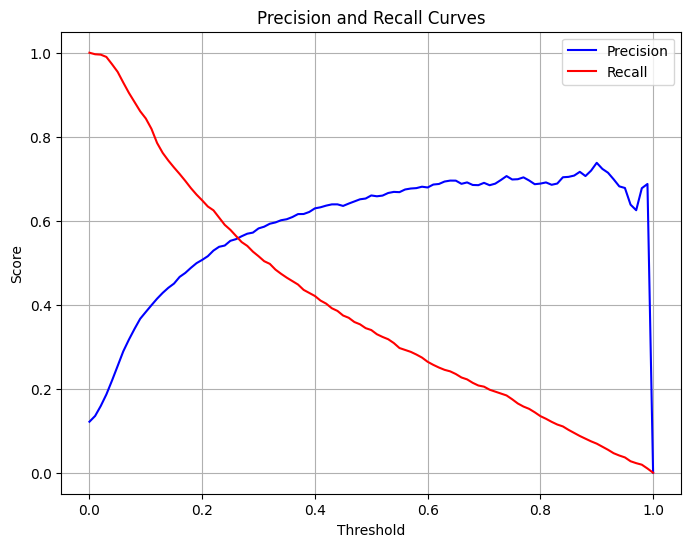

Precision and recall intersect at threshold: 0.26


In [43]:
precisions = []
recalls = []
thresholds = np.arange(0.0, 1.01, 0.01)

y_val_binary = y_val.map({'yes': 1, 'no': 0})

for threshold in thresholds:
    y_val_pred_threshold = (y_val_pred >= threshold).astype(int)
    precision = precision_score(y_val_binary, y_val_pred_threshold)
    recall = recall_score(y_val_binary, y_val_pred_threshold)
    precisions.append(precision)
    recalls.append(recall)

#Plot
plt.figure(figsize=(8, 6))
plt.plot(thresholds, precisions, label='Precision', color='b')
plt.plot(thresholds, recalls, label='Recall', color='r')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision and Recall Curves')
plt.legend(loc='best')
plt.grid(True)
plt.show()

for idx, (p, r) in enumerate(zip(precisions, recalls)):
    if np.isclose(p, r, atol=0.01):  
        intersection_threshold = thresholds[idx]
        break

print(f"Precision and recall intersect at threshold: {intersection_threshold}")

F1 scores

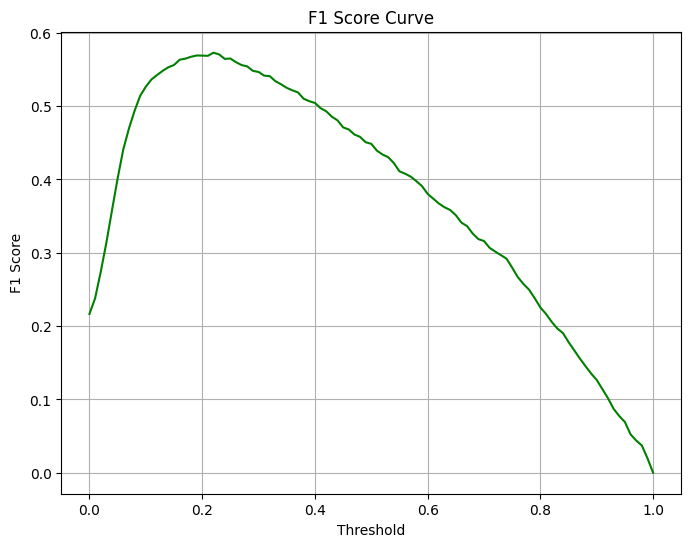

The highest F1 score is 0.573 at threshold 0.22


In [44]:
f1_scores = []

for precision, recall in zip(precisions, recalls):
    if precision + recall > 0: 
        f1 = 2 * (precision * recall) / (precision + recall)
    else:
        f1 = 0
    f1_scores.append(f1)

plt.figure(figsize=(8, 6))
plt.plot(thresholds, f1_scores, label='F1 Score', color='g')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.title('F1 Score Curve')
plt.grid(True)
plt.show()

best_threshold = thresholds[np.argmax(f1_scores)]
best_f1 = max(f1_scores)

print(f"The highest F1 score is {best_f1:.3f} at threshold {best_threshold}")


5-Fold CV

from sklearn.model_selection import KFold

In [45]:
from sklearn.model_selection import KFold
#data['y'] = data['y'].map({'yes': 1, 'no': 0})

In [46]:

df_full_train = pd.concat([pd.DataFrame(X_train), pd.DataFrame(y_train)], axis=1)
df_full_train.reset_index(drop=True, inplace=True)

print(df_full_train.columns)

kf = KFold(n_splits=5, shuffle=True, random_state=1)
dv = DictVectorizer(sparse=False)

auc_scores = []

for train_idx, val_idx in kf.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    df_train = df_train.fillna(0)
    df_val = df_val.fillna(0)
    X_train_dict = df_train.drop(columns=['y']).to_dict(orient='records')
    X_val_dict = df_val.drop(columns=['y']).to_dict(orient='records')

    X_train_encoded = dv.fit_transform(X_train_dict)
    X_val_encoded = dv.transform(X_val_dict)

    y_train = df_train['y'].values
    y_val = df_val['y'].values

    mask_train = ~pd.isnull(y_train)
    mask_val = ~pd.isnull(y_val)

    X_train_encoded = X_train_encoded[mask_train]
    y_train = y_train[mask_train]

    X_val_encoded = X_val_encoded[mask_val]
    y_val = y_val[mask_val]

    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model.fit(X_train_encoded, y_train)

    y_val_pred = model.predict_proba(X_val_encoded)[:, 1]
    auc = roc_auc_score(y_val, y_val_pred)
    auc_scores.append(auc)

#standard deviation of AUC scores
std_auc = np.std(auc_scores)
print(f'Standard Deviation of AUC Scores: {std_auc}')



Index(['age', 'job', 'marital', 'education', 'balance', 'housing', 'contact',
       'day', 'month', 'duration', 'campaign', 'pdays', 'previous', 'poutcome',
       'y'],
      dtype='object')


Standard Deviation of AUC Scores: 0.005082681501358866


In [47]:
# Assuming X_train, y_train, X_val, y_val are prepared
print(df_full_train.columns)

c_values = [0.000001, 0.001, 1]
mean_scores = []
std_scores = []

for c in c_values:
    auc_scores = []
    
    for train_idx, val_idx in kf.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        df_train = df_train.fillna(0)
        df_val = df_val.fillna(0)

        X_train_dict = df_train.drop(columns=['y']).to_dict(orient='records')
        X_val_dict = df_val.drop(columns=['y']).to_dict(orient='records')

        X_train_encoded = dv.fit_transform(X_train_dict)
        X_val_encoded = dv.transform(X_val_dict)

        y_train = df_train['y'].values
        y_val = df_val['y'].values

        mask_train = ~pd.isnull(y_train)
        mask_val = ~pd.isnull(y_val)

        X_train_encoded = X_train_encoded[mask_train]
        y_train = y_train[mask_train]

        X_val_encoded = X_val_encoded[mask_val]
        y_val = y_val[mask_val]

        model = LogisticRegression(solver='liblinear', C=c, max_iter=1000)
        model.fit(X_train_encoded, y_train)

        y_val_pred = model.predict_proba(X_val_encoded)[:, 1]
        auc = roc_auc_score(y_val, y_val_pred)
        auc_scores.append(auc)

    mean_score = np.mean(auc_scores)
    std_score = np.std(auc_scores)
    
    mean_scores.append(mean_score)
    std_scores.append(std_score)

    print(f"C = {c:.6f}: Mean Score = {mean_score:.3f}, Std = {std_score:.3f}")

best_c = c_values[np.argmax(mean_scores)]
print(f"\nBest C value: {best_c}")


Index(['age', 'job', 'marital', 'education', 'balance', 'housing', 'contact',
       'day', 'month', 'duration', 'campaign', 'pdays', 'previous', 'poutcome',
       'y'],
      dtype='object')


C = 0.000001: Mean Score = 0.698, Std = 0.005
C = 0.001000: Mean Score = 0.853, Std = 0.006
C = 1.000000: Mean Score = 0.908, Std = 0.005

Best C value: 1
